In [1]:
from extract_utils import *

# Pre-Processing Outline

1. Epochs for selected region (window=5s)
2. Transform raw data to frequency domain, look for peaks at 0.4-5 Hz
3. outliners identification -- e.g. 95% percentile
4. Filter out epochs based on:
    - peaks at 0.4-5 Hz
    - within 95% percentile of power? 


## Obtain relevant patient info

- Here we choose patient 8 for our analysis
- Figure shown below indicidates the position of electrodes on this patient

![elecLoc](Data/electrodePos/ep_sbj_08.png)

In [2]:
# get the nwb file
file, _ = get_nwb('08', 3)

/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.4.0-alpha because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Applications/anaconda3/envs/NMA/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.4.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [3]:
# table of epochs for all behavioural type
allActs, blocklist, acts, epochs = get_epochs(file, True)

# get raw data
raw = file.acquisition['ElectricalSeries'].data
# get good electrode id defined in the literature
goodid = file.electrodes.to_dataframe()[file.electrodes.to_dataframe()['good']==True].index

## Obtain Epochs for each behaviors

In [4]:
# extract all inactive activities
inactive = extract_phys_accod_timestamps(raw, epochs['Inactive'], [0, 24])
# use the average as baseline
d = []
for item in inactive.keys():
    temp = epoching(inactive[item], 500, epoch=94, max_t=94)[:, goodid.values,:]
    if not np.isnan(temp).any():
        d.append(temp) # leave only good electrodes
        

inactiveArray = np.dstack(d)
inactiveArray.shape
baseline = inactiveArray.mean(axis=2)

In [5]:
epochs_behavior = {} # Mapping behavior to corresponding epochs of 5s

for item in acts:
    # extract recording by bahvior
    if item == 'Inactive' or item=='Other activity' or item=='Sleep/rest':
        pass
    else:
        temp = extract_phys_accod_timestamps(raw, epochs[item], [0, 24])
        # obtain epochs for each behaviour
        d = []
        for key in temp.keys():
            d.append(epoching(temp[key], 500, 94, max_t=94)[:, goodid.values,:]) # leave only good electrodes
        epochs_behavior[item] = np.dstack(d)

## Power Transform

In [6]:
import fooof as f
import scipy
from scipy.signal import welch, firwin, fftconvolve, hilbert
from scipy.fft import ifft
from scipy.signal import sosfilt

In [7]:
acts = ['Computer/phone',
 'Eat, TV',
 'TV',
 'TV, Computer/phone',
 'Talk',
 'Talk, Computer/phone',
 'Talk, TV',
 'Talk, TV, Computer/phone']

In [8]:
# 2th order IIR filter to extract low-frequence envelop
filter_order = 2
neural_freq_range = [0.5, 5]
sampling_rate = 500
filtered_data = {}
for item in acts:
        item_specific = np.empty((epochs_behavior[item].shape))
        for j in range(epochs_behavior[item].shape[1]):
                neur_data_curr = epochs_behavior[item][:, j, :]
                sos = butter(filter_order, neural_freq_range, btype='bandpass', output='sos', fs=sampling_rate)
                item_specific[:, j, :] = sosfiltfilt(sos, neur_data_curr, padlen=0)
        filtered_data[item] = item_specific

In [9]:
epochs_behavior[item].shape

(47000, 83, 1)

In [10]:
freqb, spectrumb = welch(baseline[:, -1], 500, scaling='spectrum')

In [11]:
# Select epochs with power within 99% percentile

epoch_id = {}
tl, n_channel, n_epoch = epochs_behavior['TV'].shape
powerSpec = np.empty((tl, n_channel, n_epoch))
filtered_epochs = {}

l_c = []
filtered_epochs['TV'] = {}
for j in range(n_channel): # for each channel
    
    channel_curr = []
    for i in range(n_epoch): # for each epoch
        # Hilbert transform on filtered data
        # powerSpec[:, j, i] = np.abs(hilbert(filtered_data['TV'][:, j, i], ))
        # channel_curr.append(power)
        # welch transform
        freqs, spectrum = welch(epochs_behavior['TV'][:, j, i], fs=500, scaling='density')
        #spectrum = 10*np.log10(spectrum/spectrumb)
        channel_curr.append(np.mean(spectrum[0:3]))
    lb, ub = np.percentile(channel_curr, [5, 95])
    idx = np.where(np.logical_and(channel_curr<=ub, channel_curr>=lb))
    l_c.append(len(idx[0]))
    filtered_epochs['TV'][j] = epochs_behavior['TV'][:, j, idx]

minlidx = min(l_c)
epochf = np.empty((tl, n_channel, minlidx))
for j in range(n_channel):
    t, lepoch = filtered_epochs['TV'][j].shape[0], filtered_epochs['TV'][j].shape[-1]
    filtered_epochs['TV'][j] = filtered_epochs['TV'][j].reshape(t, lepoch)
    epochf[:, j, :] = filtered_epochs['TV'][j][:, 0:minlidx]

# (filtered_data['TV'][:, :, i] - np.mean(baseline, axis=1))/std()

In [13]:
# z-scoring
for i in range(n_epoch):
    powerSpec[:, :, i] = (powerSpec[:, :, i] - np.mean(baseline, axis=0)
)/np.std(baseline, axis=0)

(0.0, 50.0)

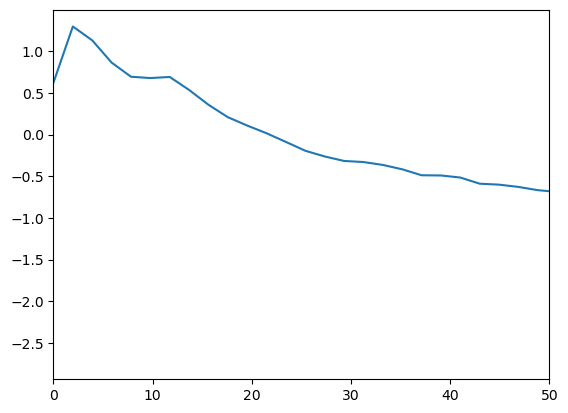

In [14]:
plt.plot(freqs, np.log10(spectrum))
plt.xlim([0, 50])

## MNE demo

In [15]:
from mne.viz import plot_raw_psd
import mne

In [16]:
sample = epochs_behavior['TV']
sample.shape

(47000, 83, 23)

In [17]:
sampleinfo = mne.create_info([str(id) for id in goodid], 500, 'ecog')
epochObj = mne.EpochsArray(sample.reshape((23, 83, 47000)), sampleinfo)

Not setting metadata
23 matching events found
No baseline correction applied
0 projection items activated


# Demixed PCA